# Interval Fit

In [8]:
import pandas as pd
import numpy as np
import os
import pickle

from datetime import datetime

from sklearn.metrics import make_scorer
from scipy import optimize
from scipy import integrate

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.base import BaseEstimator,RegressorMixin
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import GridSearchCV

sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)

%matplotlib inline

In [10]:
country = 'India'
df_analyse=pd.read_csv('Processed/COVID_Small_Flat_Table.csv',sep=';')  
df_analyse.sort_values('date',ascending=True).head()

,date,Italy,US,India,Germany,"Korea, South"
0,2020-01-22,0,1,0,0,1
1,2020-01-23,0,1,0,0,1
2,2020-01-24,0,2,0,0,2
3,2020-01-25,0,2,0,0,2
4,2020-01-26,0,5,0,0,3


In [11]:
def set_parameters(df_analyse, country):
  
    
    # set N0 value for particular country
    
    # get index for country with more than 100 cases as start point
    n = df_analyse[df_analyse[country] >= 1000][country] .idxmin()
    print(n)
    
    # store infected cases 
    ydata = np.array(df_analyse[country][n:])
    
    # get day index
    t=np.arange(0, len(ydata))
    
    return ydata, t, 

In [12]:

ydata, t = set_parameters(df_analyse, country)

# initalization for SIR_model
N0=10000000 #max susceptible population
I0=ydata[0]
S0=N0-I0
R0=0

67


In [13]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [14]:
def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), x, args=(beta, gamma))[:,1] 

In [15]:
ydata = np.array(df_analyse.India[30:120])
t=np.arange(len(ydata))

In [16]:
# ensure re-initialization 
N0=1000000 
beta=0.4   # infection spread dynamics
gamma=0.1 # recovery rate
I0=ydata[0]
S0=N0-I0
R0=0
beta

0.4

In [17]:
# example curve of our differential equation
popt=[0.4,0.1]
initial_fit = fit_odeint(t, *popt)

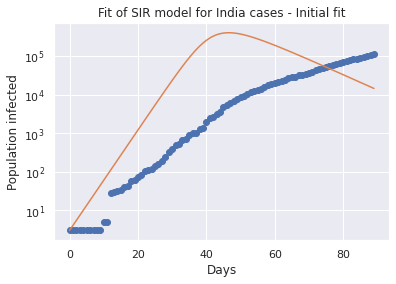

In [18]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, initial_fit)
plt.title("Fit of SIR model for India cases - Initial fit")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()

In [33]:
interval_fitted = np.array([])
interval = 60

for i in range(4):

  ydata = np.array(df_analyse.India[i*60:i*60+60])
  t=np.arange(len(ydata))
  popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
  perr = np.sqrt(np.diag(pcov))
      
  print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
  print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
  fitted=fit_odeint(t, *popt)
  interval_fitted = np.hstack((interval_fitted, fitted))

# print(interval_fitted)


standard deviation errors :  [98.07762704 98.08561665]  start infect: 0
Optimal parameters: beta = -0.0012827916563573922  and gamma =  -0.07208644450264937


/usr/local/lib/python3.6/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in double_scalars
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars


standard deviation errors :  [0.01189328 0.01087761]  start infect: 396
Optimal parameters: beta = 0.537653757896442  and gamma =  0.31704102838351184
standard deviation errors :  [0.0103721  0.00344781]  start infect: 118226
Optimal parameters: beta = 0.3718303840774599  and gamma =  0.007537576976783782
standard deviation errors :  [6.48485909e+01 4.68489780e-02]  start infect: 1155338
Optimal parameters: beta = 41.65135724565515  and gamma =  -0.06641128185955951


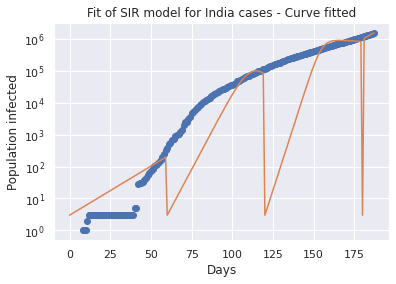

Optimal parameters: beta = 41.65135724565515  and gamma =  -0.06641128185955951
Basic Reproduction Number R0  -627.1729151943734
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [34]:
ydata = np.array(df_analyse.India)
t=np.arange(len(ydata))
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, interval_fitted)
plt.title("Fit of SIR model for India cases - Curve fitted")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")